In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize']=20,8
plt.style.use('ggplot')

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
raw_df = pd.read_csv("/kaggle/input/online-retail-customer-clustering/OnlineRetail.csv", encoding= 'unicode_escape')

# Cleaning the data

## Dropping columns

In [3]:
# drop useless columns
raw_df.drop(['StockCode', 'InvoiceDate','Description','Country'],axis = 1, inplace =True)

In [4]:
print(raw_df["Quantity"].min())
print(raw_df["UnitPrice"].min())

-80995
-11062.06


In [5]:
df = raw_df.loc[raw_df["Quantity"] >0 ]
df = df.loc[df["UnitPrice"] >0 ]

In [6]:
# creating a new column of Total amount
df["Total"]=df["Quantity"]*df["UnitPrice"]

In [7]:
# dropping 'Quantity' and 'UnitPrice'
df.drop(['Quantity', 'UnitPrice'],axis = 1, inplace =True)

In [8]:
# Checking data for the missing values
df.isnull().sum()

InvoiceNo          0
CustomerID    132220
Total              0
dtype: int64

In [9]:
# Dropping the missing value in customerId .
df.dropna(axis = 0, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   InvoiceNo   397884 non-null  object 
 1   CustomerID  397884 non-null  float64
 2   Total       397884 non-null  float64
dtypes: float64(2), object(1)
memory usage: 12.1+ MB


## Adding columns

In [11]:
# amount
amount=df.groupby('CustomerID')['Total'].sum().reset_index()
amount.columns=['CustomerID','Amount']

# amount
freq=df.groupby('CustomerID')['InvoiceNo'].count().reset_index()
freq.columns=['CustomerID','Frequency']

# merge both into df
df1=pd.merge(amount, freq, on='CustomerID', how='inner')
df1.head()

,CustomerID,Amount,Frequency
0,12346.0,77183.60,1
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [12]:
# dropping 'CustomerID'
df1.drop(['CustomerID'],axis = 1, inplace =True)

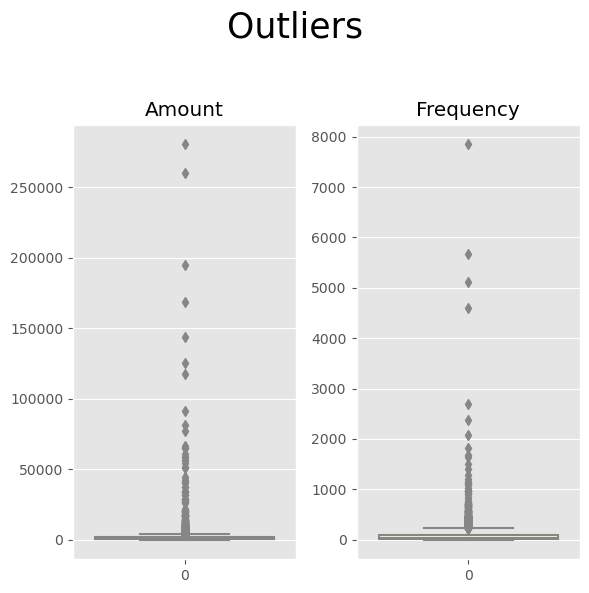

In [13]:
## Outliers in the dataset
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(6,6))
fig.suptitle('Outliers\n', size = 25)

sns.boxplot(ax=axes[0], data=df1['Amount'], palette='Spectral').set_title("Amount")
sns.boxplot(ax=axes[1], data=df1['Frequency'], palette='Spectral').set_title("Frequency")

plt.tight_layout()

### Remove outliers with isolation forest

In [14]:
from sklearn.ensemble import IsolationForest
df2 = df1.copy()

In [15]:
# Model building
model=IsolationForest(n_estimators=150, max_samples='auto', contamination=float(0.1), max_features=1.0)
model.fit(df2)

IsolationForest(contamination=0.1, n_estimators=150)

In [16]:
# Adding 'scores' and 'anomaly' colums to df
scores=model.decision_function(df2)
anomaly=model.predict(df2)

df2['scores']=scores
df2['anomaly']=anomaly

anomaly = df2.loc[df2['anomaly']==-1]
anomaly_index = list(anomaly.index)
print('Total number of outliers is:', len(anomaly))

Total number of outliers is: 434


In [17]:
# dropping outliers
df2 = df2.drop(anomaly_index, axis = 0).reset_index(drop=True)

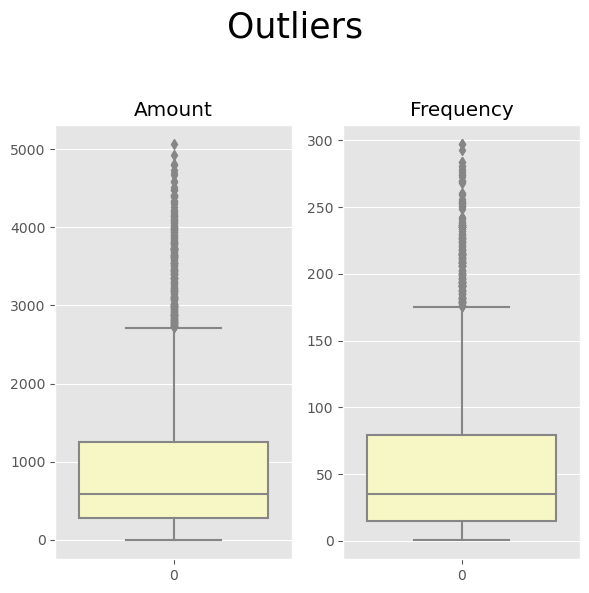

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(6,6))
fig.suptitle('Outliers\n', size = 25)

sns.boxplot(ax=axes[0], data=df2['Amount'], palette='Spectral').set_title("Amount")
sns.boxplot(ax=axes[1], data=df2['Frequency'], palette='Spectral').set_title("Frequency")

plt.tight_layout()

In [19]:
# dropping columns that we don't need any more
df2.drop(['scores', 'anomaly'], axis = 1, inplace =True)

## Scaling data

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df3=scaler.fit_transform(df2)

# Determining number of clusters

## Elbow method


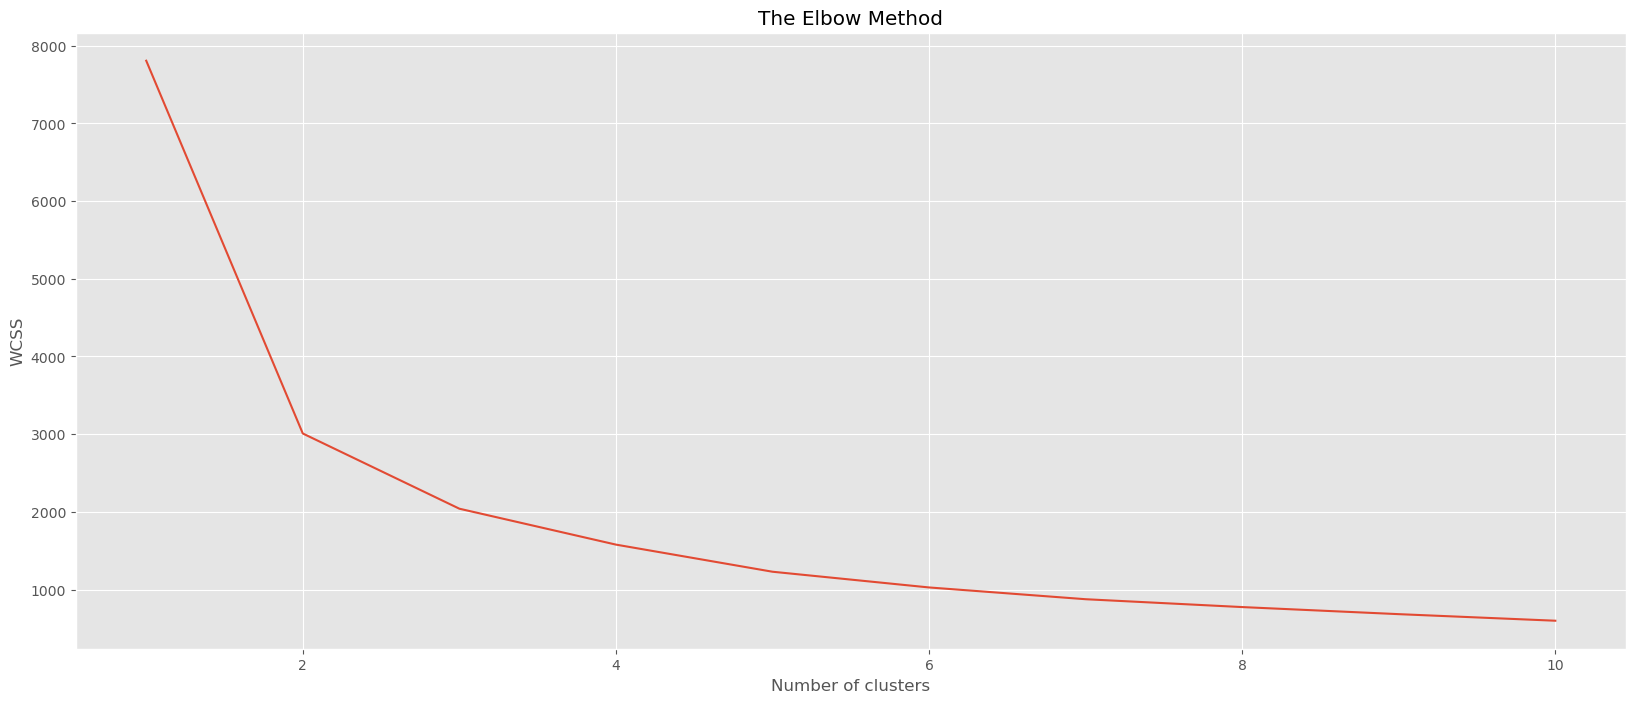

In [21]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df3)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

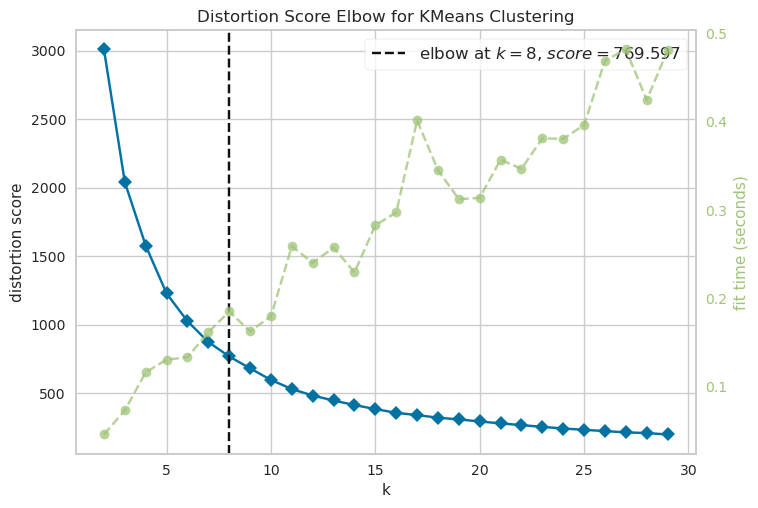

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(df3)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

## Silhouette method

In [23]:
from sklearn import datasets
from sklearn.metrics import silhouette_score

# Instantiate the KMeans for 5 clusters
km = KMeans(n_clusters=7, random_state=42)
# Fit the KMeans model
km.fit_predict(df3)
# Calculate Silhoutte Score
score = silhouette_score(df3, km.labels_, metric='euclidean')
# Print the score
print('Silhouetter Average Score: %.3f' % score)

Silhouetter Average Score: 0.430


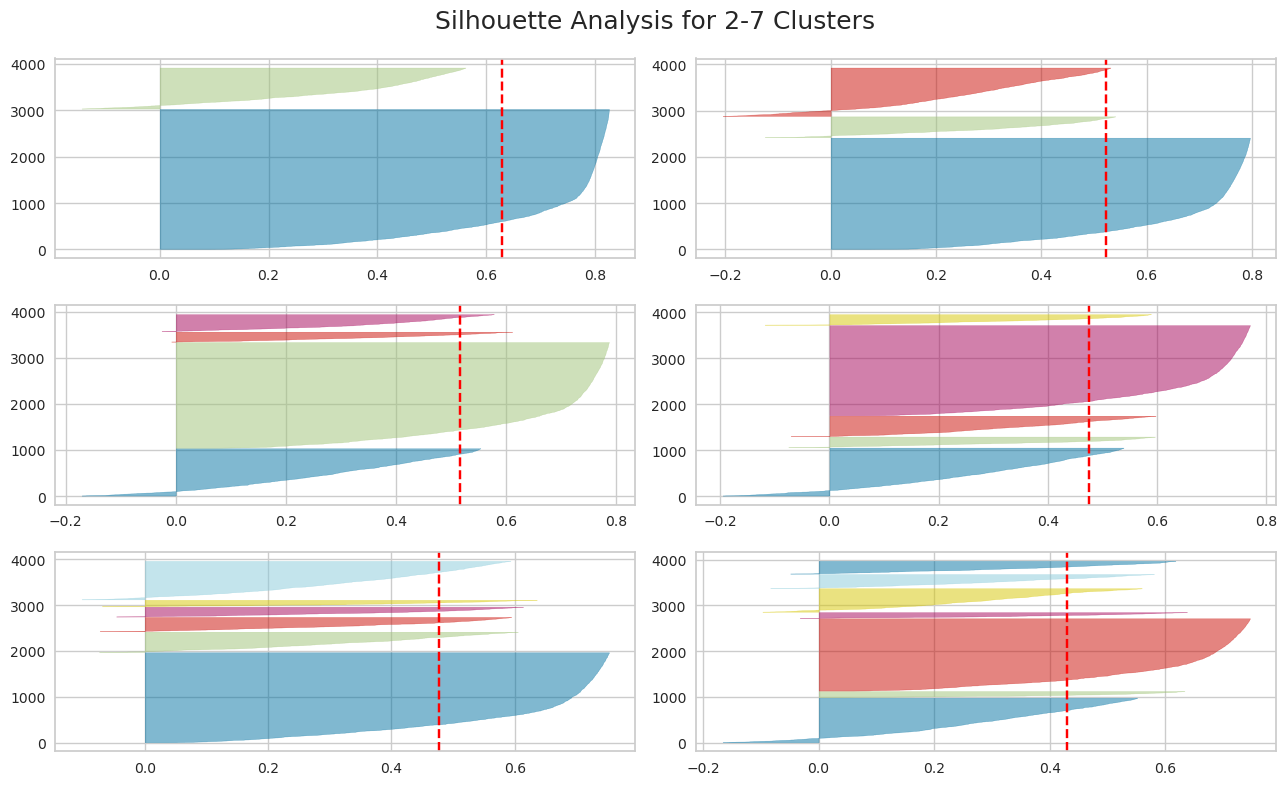

In [24]:
from yellowbrick.cluster import SilhouetteVisualizer

# Yellowbrick extends the Scikit-Learn API to make model selection and hyperparameter tuning easier.
# You can find the code to simply create Silhouette visualisation for K-Means clusters with n_cluster as 2, 3, 4, 5, 6, 7 below.

fig, ax = plt.subplots(3, 2, figsize=(13,8))
fig.suptitle('Silhouette Analysis for 2-7 Clusters', size = 18)
plt.tight_layout()

for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df3)

## Dendogram

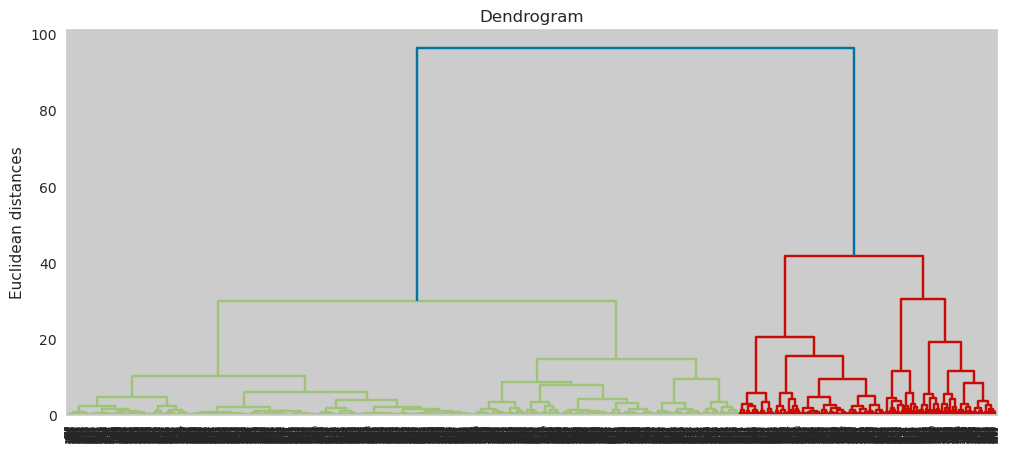

In [25]:
import scipy.cluster.hierarchy as sch
from matplotlib import pyplot
pyplot.figure(figsize=(12, 5))
dendrogram = sch.dendrogram(sch.linkage(df3, method = 'ward'))
plt.title('Dendrogram')
plt.ylabel('Euclidean distances')
plt.show()

## K-means

In [26]:
df_kmeans = df3.copy()

# Training model
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(df_kmeans)

In [27]:

# We called the df, that's why we need to refer to previous df to add cluster numbers
df_kmeans = df2.copy()
# Checking number of items in clusters and creating 'Cluster' column
df_kmeans['Cluster'] = y_kmeans
df_kmeans['Cluster'].value_counts()

0    1961
5     839
1     439
2     311
3     212
4     142
Name: Cluster, dtype: int64

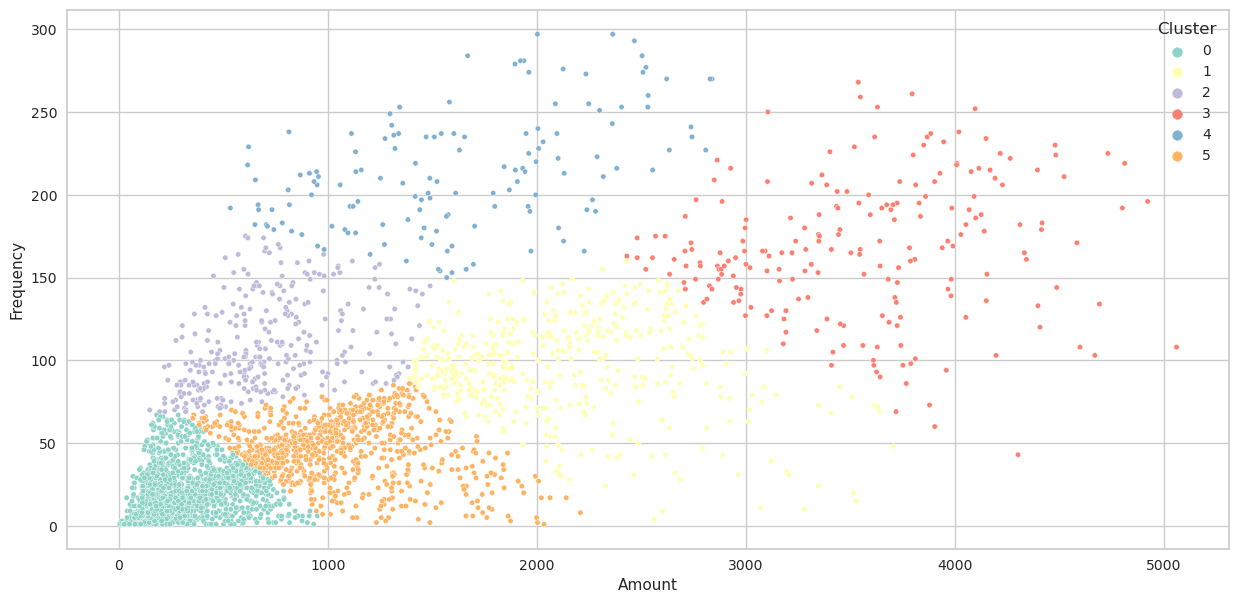

In [28]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=df_kmeans, x='Amount', y='Frequency', hue = 'Cluster', s=15, palette="Set3");

## DBSCAN

In [29]:
# Copying data sets
df_DBScan = df3.copy()

# Training model
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=20, min_samples=9, metric='euclidean')
y_DBScan = dbscan.fit_predict(df_DBScan)

In [30]:
# We called the df, that's why we need to refer to previous df to add cluster numbers
df_DBScan = df2.copy()
# Checking number of items in clusters and creating 'Cluster' column
df_DBScan['Cluster'] = y_DBScan
df_DBScan['Cluster'].value_counts()

0    3904
Name: Cluster, dtype: int64

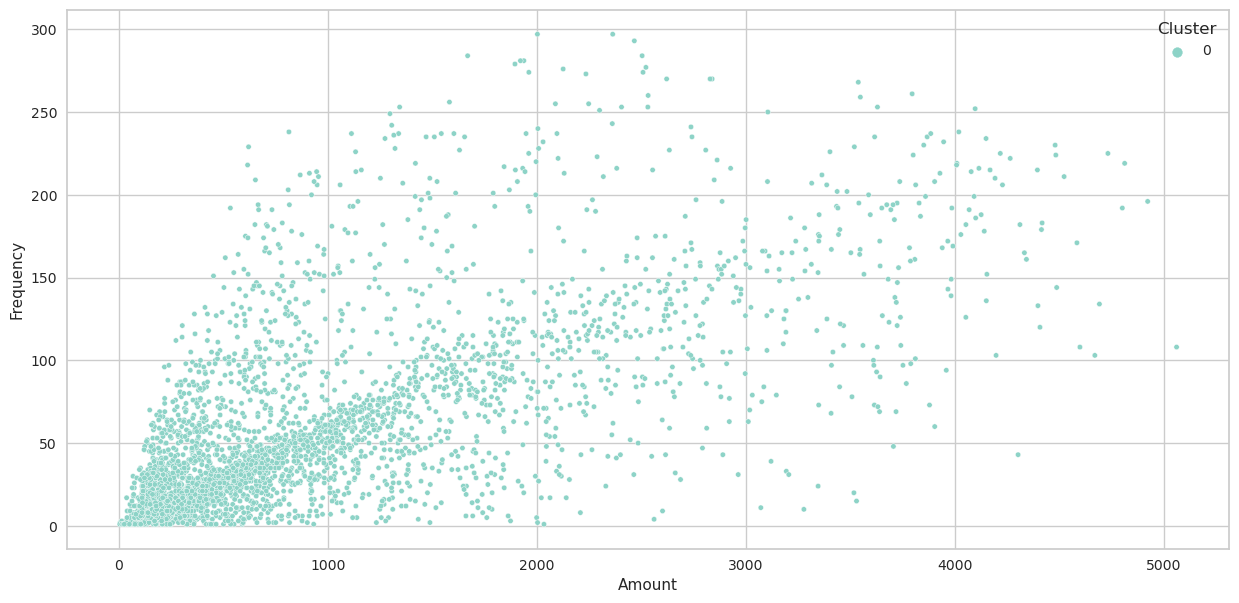

In [31]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=df_DBScan, x='Amount', y='Frequency', hue = 'Cluster', s=15, palette="Set3");

## Gassian Matrix Models

In [32]:
# Copying data sets
df_GMM = df3.copy()

# Training model
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=8)
y_GMM = gmm.fit_predict(df_GMM)

In [33]:
# We called the df, that's why we need to refer to previous df to add cluster numbers
df_GMM = df2.copy()
# Checking number of items in clusters and creating 'Cluster' column
df_GMM['Cluster'] = y_GMM
df_GMM['Cluster'].value_counts()

0    1088
7    1021
4     597
6     403
1     334
2     242
3     121
5      98
Name: Cluster, dtype: int64

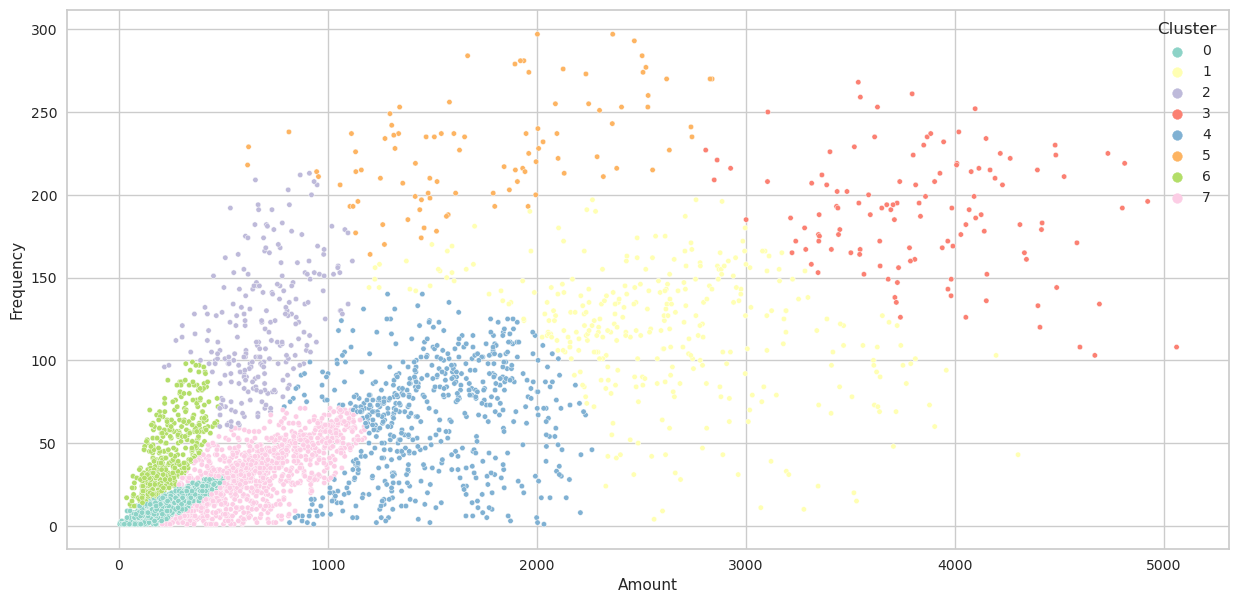

In [34]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=df_GMM, x='Amount', y='Frequency', hue = 'Cluster', s=15, palette="Set3");